# Deepfake Detection: Model Training and Evaluation
## Team Quarks (Ali & Belal)
## Objective
The objective of this notebook is to employ machine learning models to assess the predictive power of the facial landmark variance feature, which was identified as a potential indicator during our EDA.
## Data Description
The dataset consists of facial landmark data extracted from a series of videos. Each entry in the dataset represents a video and includes the variance of facial landmark velocities in the X and Y axes, as well as the percentage of frames in which a face was successfully detected.

In [1]:
import os
import pandas as pd
import json

def create_dataframe_from_json(directory):
    data = []
    errors = []

    # List all files in the given directory
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)

            try:
                # Read the JSON file
                with open(file_path, 'r') as file:
                    json_data = json.load(file)
                    
                # Start the dictionary with the video name
                video_data = {'video_name': filename.replace('.json', '')}
                # Update this dictionary with the overall_features
                video_data.update(json_data.get("overall_features", {}))

                data.append(video_data)

            except Exception as e:
                errors.append((filename, str(e)))

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Rename columns to be more descriptive
    column_renaming = {
        'chin_xvel_var': 'Chin X-Axis Velocity Variance',
        'chin_yvel_var': 'Chin Y-Axis Velocity Variance',
        'left_eyebrow_xvel_var': 'Left Eyebrow X-Axis Velocity Variance',
        'left_eyebrow_yvel_var': 'Left Eyebrow Y-Axis Velocity Variance',
        'right_eyebrow_xvel_var': 'Right Eyebrow X-Axis Velocity Variance',
        'right_eyebrow_yvel_var': 'Right Eyebrow Y-Axis Velocity Variance',
        'nose_bridge_xvel_var': 'Nose Bridge X-Axis Velocity Variance',
        'nose_bridge_yvel_var': 'Nose Bridge Y-Axis Velocity Variance',
        'nose_tip_xvel_var': 'Nose Tip X-Axis Velocity Variance',
        'nose_tip_yvel_var': 'Nose Tip Y-Axis Velocity Variance',
        'left_eye_xvel_var': 'Left Eye X-Axis Velocity Variance',
        'left_eye_yvel_var': 'Left Eye Y-Axis Velocity Variance',
        'right_eye_xvel_var': 'Right Eye X-Axis Velocity Variance',
        'right_eye_yvel_var': 'Right Eye Y-Axis Velocity Variance',
        'top_lip_xvel_var': 'Top Lip X-Axis Velocity Variance',
        'top_lip_yvel_var': 'Top Lip Y-Axis Velocity Variance',
        'bottom_lip_xvel_var': 'Bottom Lip X-Axis Velocity Variance',
        'bottom_lip_yvel_var': 'Bottom Lip Y-Axis Velocity Variance',
        'face_detection_percentage': 'Face Detection Percentage',
        'label': 'Video Authenticity Label'
    }
    df = df.rename(columns=column_renaming)

    return df, errors

directory_path = "/data1/belalm/Capstone/data/landmarks"
df, errors = create_dataframe_from_json(directory_path)

print(df) 

if errors:
    print("Errors encountered:")
    for error in errors:
        print(error)

       video_name  Chin X-Axis Velocity Variance  \
0      hyhjfdxqxy                       0.495092   
1      lcxsmhpfbm                       0.484788   
2      rbttksdaen                            NaN   
3      fahbidqhcx                            NaN   
4      mrmaimxhjn                       2.400303   
...           ...                            ...   
24343  kverutwcbw                       0.661452   
24344  trvqryiuqr                       1.929244   
24345  hyzeitilgy                      62.350724   
24346  mvfeurfoyq                       0.531911   
24347  cnzxvjdwbw                       0.553393   

       Chin Y-Axis Velocity Variance  Left Eyebrow X-Axis Velocity Variance  \
0                           2.280703                               0.916649   
1                           1.515197                               1.699149   
2                                NaN                                    NaN   
3                                NaN                       

## Model Testing
In this section, we load the preprocessed data and implement several machine learning models to assess their performance.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

X = df.drop(['video_name', 'Video Authenticity Label'], axis=1)
y = df['Video Authenticity Label'].map({'FAKE': 0, 'REAL': 1})  # Convert labels to binary

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Impute missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features to be used by SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

## Model Selection Rationale
### Logistic Regression, Random Forest, Gradient Boosting
- Chosen for their efficacy in binary classification tasks.
- **Assumptions and Limitations:** Each model's assumptions are evaluated against the data characteristics.
- **Model Comparisons:** Theoretical and practical aspects are compared.

## Cross-Validation Strategy
### 5-Fold Cross-Validation
- Ensures robust performance estimation.
- Results imply model generalizability.

## Train a Logistic Regression model

Here, a Logistic Regression model is initialized and trained using the imputed and scaled training data (`X_train_scaled` and `y_train`). The trained model is used to predict the labels for the imputed and scaled test set (`X_test_scaled`) and the accuracy of the predictions is evaluated using the `accuracy_score` function. The accuracy score is printed to the console. `classification_report` is used generate a detailed report that includes precision, recall, F1-score, and support for each class.

In [3]:
# Initialize the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train the model using the imputed and scaled training data
logistic_model.fit(X_train_scaled, y_train)

# Predict on the imputed and scaled test set
logistic_predictions = logistic_model.predict(X_test_scaled)

# Evaluate the Logistic Regression model
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression Accuracy: {logistic_accuracy}")
print(classification_report(y_test, logistic_predictions))

Logistic Regression Accuracy: 0.5464065708418891
              precision    recall  f1-score   support

           0       0.60      0.26      0.36      2412
           1       0.53      0.83      0.65      2458

    accuracy                           0.55      4870
   macro avg       0.56      0.54      0.51      4870
weighted avg       0.56      0.55      0.51      4870



In this code, the `cross_val_score` function from the `sklearn.model_selection` module is used to perform 5-fold cross-validation for the Logistic Regression model. 

The `cross_val_score` function takes as input the trained Logistic Regression model (`logistic_model`), the scaled training data (`X_train_scaled`), and the corresponding labels (`y_train`). It performs 5-fold cross-validation by splitting the data into 5 subsets and trains the model on 4 subsets while evaluating its performance on the remaining subset. 

The function returns an array of scores, representing the evaluation metric (accuracy by default) for each fold. The mean score is then calculated using the `mean()` method of the array. 

In this code, the cross-validation scores for the Logistic Regression model are fairly even, with an average of `53.3%`

In [4]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Logistic Regression
logistic_cv_scores = cross_val_score(logistic_model, X_train_scaled, y_train, cv=5)
print(f"Logistic Regression CV scores: {logistic_cv_scores}")
print(f"Logistic Regression CV mean score: {logistic_cv_scores.mean()}")

Logistic Regression CV scores: [0.53336756 0.55159138 0.52797741 0.52272144 0.53145058]
Logistic Regression CV mean score: 0.5334216720747127


Next, we calculate the probabilities of each class using the trained Logistic Regression model (`logistic_model`) and the scaled test data (`X_test_scaled`). 

We also calculate the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) for the Logistic Regression model. The ROC curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1 - specificity) at various classification thresholds. The AUC represents the overall performance of the model, with a higher value indicating better performance.

Finally, we plot the ROC curve using matplotlib. This plot helps us visualize the performance of the Logistic Regression model in distinguishing between the two classes.

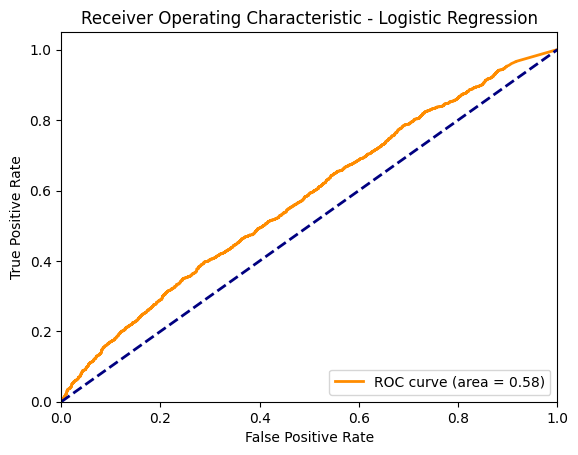

In [5]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the probabilities of each class
logistic_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and ROC AUC
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_probs)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plot ROC curve
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_logistic)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


The ROC curve for the logistic regression model yielded an AUC of 0.58, indicating a moderate predictive ability.


In this code, the logistic regression model is used to make predictions on the training data. The in-sample accuracy represents the model's performance on the training data, while the out-of-sample accuracy represents its performance on the test data. The calculated accuracies are roughly equivalent, at around `53%`

In [6]:
# Logistic Regression - In-Sample and Out-of-Sample Results
logistic_in_sample_preds = logistic_model.predict(X_train_scaled)
logistic_in_sample_accuracy = accuracy_score(y_train, logistic_in_sample_preds)

print(f"Logistic Regression In-sample Accuracy: {logistic_in_sample_accuracy}")
print(f"Logistic Regression Out-of-Sample Accuracy: {logistic_accuracy}")

Logistic Regression In-sample Accuracy: 0.5335250025669986
Logistic Regression Out-of-Sample Accuracy: 0.5464065708418891


## Train a Random Forest Classifier

In this code, a Random Forest Classifier model is initialized and trained using the imputed training data. Random Forest Classifiers are a type of ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees. They are effective for dealing with overfitting, a common problem with decision trees. They are also good for handling large datasets with high dimensionality, as they can maintain accuracy even when a large proportion of the data are missing.

As we can see, we have a much better accuracy level at around `65%`

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model on the imputed data (no need to scale for tree-based models)
rf_model.fit(X_train_imputed, y_train)

# Predict on the imputed test set
rf_predictions = rf_model.predict(X_test_imputed)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.6484599589322382
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      2412
           1       0.66      0.62      0.64      2458

    accuracy                           0.65      4870
   macro avg       0.65      0.65      0.65      4870
weighted avg       0.65      0.65      0.65      4870



Similarly, we perform cross validation, and we receive a similarly balanced set of scores, averaging at `64%`

In [8]:
# Perform 5-fold cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train_imputed, y_train, cv=5)
print(f"Random Forest CV scores: {rf_cv_scores}")
print(f"Random Forest CV mean score: {rf_cv_scores.mean()}")

Random Forest CV scores: [0.63526694 0.64168378 0.64117043 0.64646983 0.62978177]
Random Forest CV mean score: 0.6388745509037279


We calculate the in and out-of sample accuracy levels. Interestingly, we see a more drastic difference, with in-sample accuracy at around `50%` and the out of sample accuracy at `66%`

In [9]:
# Random Forest - In-Sample and Out-of-Sample Results
rf_in_sample_preds = rf_model.predict(X_train_scaled)
rf_in_sample_accuracy = accuracy_score(y_train, rf_in_sample_preds)

print(f"Random Forest In-sample Accuracy: {rf_in_sample_accuracy}")
print(f"Random Forest Out-of-Sample Accuracy: {rf_accuracy}")

Random Forest In-sample Accuracy: 0.5036964780778314
Random Forest Out-of-Sample Accuracy: 0.6484599589322382


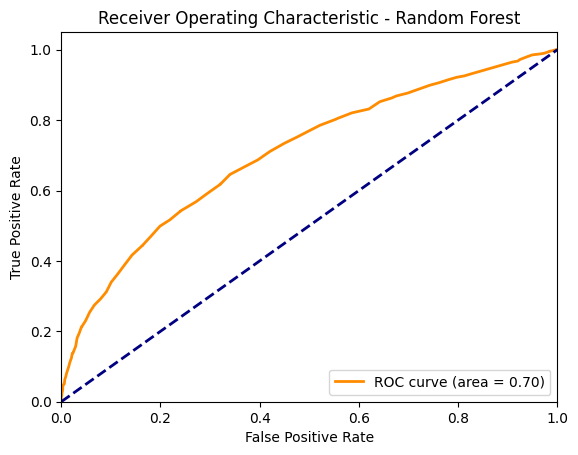

In [10]:
# Random Forest: Calculate the probabilities of the positive class
rf_probs = rf_model.predict_proba(X_test_imputed)[:, 1]

# Calculate the ROC curve and ROC AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve for Random Forest
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

The ROC curves and the Area under the Curve are very different than the logistic regression, with an area of 0.71 which indicates a better rate.

## Train a Gradient Boosting Classifier

Next, we are going to train a model using a gradient boosting classifier. This is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function. It's often used due to its predictive power and efficiency on structured data.

Here, we receive an accuracy score of `61%`

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the Gradient Boosting model on the imputed data
gb_model.fit(X_train_imputed, y_train)

# Predict on the imputed test set
gb_predictions = gb_model.predict(X_test_imputed)

# Evaluate the Gradient Boosting model
gb_accuracy = accuracy_score(y_test, gb_predictions)
print(f"Gradient Boosting Accuracy: {gb_accuracy}")
print(classification_report(y_test, gb_predictions))

Gradient Boosting Accuracy: 0.6182751540041068
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      2412
           1       0.63      0.59      0.61      2458

    accuracy                           0.62      4870
   macro avg       0.62      0.62      0.62      4870
weighted avg       0.62      0.62      0.62      4870



By performing cross validation, we can see an extremely well balanced set of scores, averaging at `61.8%` accuracy

In [12]:
# Perform 5-fold cross-validation for Gradient Boosting
gb_cv_scores = cross_val_score(gb_model, X_train_imputed, y_train, cv=5)
print(f"Gradient Boosting CV scores: {gb_cv_scores}")
print(f"Gradient Boosting CV mean score: {gb_cv_scores.mean()}")

Gradient Boosting CV scores: [0.60318275 0.61216632 0.61652977 0.62721438 0.6156611 ]
Gradient Boosting CV mean score: 0.6149508662978124


Similarly to the Random Forest Classifier, we see a higher level of out-of-sample accuracy. Traditionally, when we have higher out-of-sample accuracy levels, it indicates that the model is underfitting, and could gain more insights and patterns from the data. Since our dataset is so diverse, this is expected.

In [13]:
# Gradient Boosting - In-Sample and Out-of-Sample Results
gb_in_sample_preds = gb_model.predict(X_train_scaled)
gb_in_sample_accuracy = accuracy_score(y_train, gb_in_sample_preds)

print(f"Gradient Boosting In-sample Accuracy: {gb_in_sample_accuracy}")
print(f"Gradient Boosting Out-of-Sample Accuracy: {gb_accuracy}")

Gradient Boosting In-sample Accuracy: 0.5035424581579218
Gradient Boosting Out-of-Sample Accuracy: 0.6182751540041068


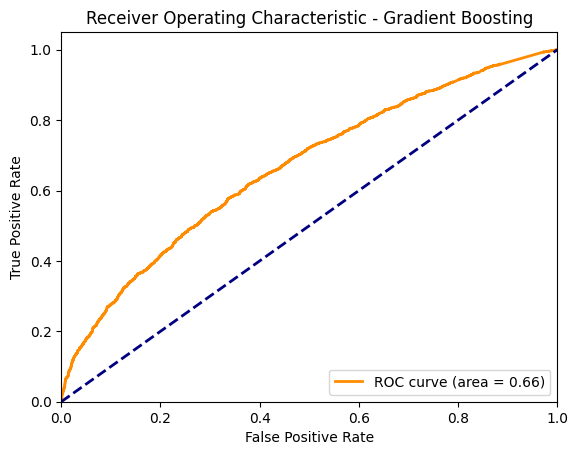

In [14]:
# Gradient Boosting: Calculate the probabilities of the positive class
gb_probs = gb_model.predict_proba(X_test_imputed)[:, 1]

# Calculate the ROC curve and ROC AUC for Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_probs)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot the ROC curve for Gradient Boosting
plt.figure()
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

The ROC curve for the Gradient Boosting model achieved an AUC of 0.66, signifying a reasonably good level of predictive accuracy.


### Learning Curve

In this code, a function called `calculate_f1_scores` is defined. This function takes a machine learning model, feature data (`X`), target data (`y`), a list of fractions (`increments`) representing the sizes of the training data to be used, an imputer object (`imputer`) for handling missing values, and a scaler object (`scaler`) for feature scaling.

The function iterates over each fraction in the `increments` list. For each fraction, it splits the feature and target data into a training set (`X_sample`, `y_sample`) and a validation set. It then imputes missing values and scales the training data using the provided imputer and scaler objects.

The model is trained on the imputed and scaled training data. Predictions are made on the training data, and the F1 score is calculated by comparing the predictions to the actual target values.

The function is then called with the logistic regression model (`LogisticRegression(max_iter=1000)`), the feature data (`X_train`), target data (`y_train`), the fractions array, and the imputer and scaler objects. The returned F1 scores for logistic regression are stored in the `f1_scores_logistic` variable.

Finally, a plot is created using to visualize the relationship between the fraction of training data used and the F1 score for logistic regression.

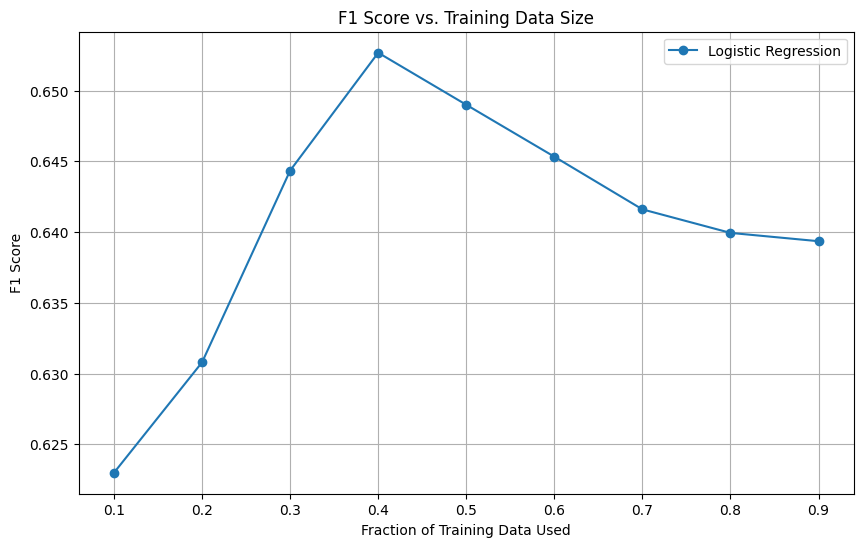

In [15]:
from sklearn.metrics import f1_score
import numpy as np

def calculate_f1_scores(model, X, y, increments, imputer, scaler):
    f1_scores = []
    for frac in increments:
        # Splitting the data
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=frac, shuffle=False)
        
        # Impute and scale the sample
        X_sample_imputed = imputer.fit_transform(X_sample)
        X_sample_scaled = scaler.fit_transform(X_sample_imputed)
        
        # Training the model
        model.fit(X_sample_scaled, y_sample)
        
        # Making predictions and calculating F1 score
        predictions = model.predict(X_sample_scaled)
        score = f1_score(y_sample, predictions)
        f1_scores.append(score)
    
    return f1_scores
fractions = np.linspace(0.1, 0.9, 9)  # Adjusted fractions, excluding 1.0
f1_scores_logistic = calculate_f1_scores(LogisticRegression(max_iter=1000), X_train, y_train, fractions, imputer, scaler)

plt.figure(figsize=(10, 6))
plt.plot(fractions, f1_scores_logistic, marker='o', label='Logistic Regression')
plt.title('F1 Score vs. Training Data Size')
plt.xlabel('Fraction of Training Data Used')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

As can be seen, the F1 score sharpy increases with more data, leading up to a maximum of around 65.5% accuracy with 40% of the data. It then starts decreasing steadily as we add more to our training data. Since our dataset is diverse and has a plethora of different representations and formats, we expect that the harm of overfitting is very drastic, and we can observe that here. The regression model should reach a certain degree of information that can predict any of the data in a balanced manner, but not exceed the amount of information needed.

### Log Loss

In [28]:
from sklearn.metrics import log_loss

# Calculate the log loss for the Logistic Regression model
log_loss_logistic = log_loss(y_test, logistic_probs)
print(f"Log Loss for Logistic Regression: {log_loss_logistic}")

# Calculate the probabilities of each class for the Random Forest model
rf_probs = rf_model.predict_proba(X_test_imputed)[:, 1]

# Calculate the log loss for the Random Forest model
log_loss_rf = log_loss(y_test, rf_probs)
print(f"Log Loss for Random Forest: {log_loss_rf}")

# Gradient Boosting: Calculate the probabilities of the positive class
gb_probs = gb_model.predict_proba(X_test_imputed)[:, 1]

# Calculate the log loss for the Gradient Boosting model
log_loss_gb = log_loss(y_test, gb_probs)
print(f"Log Loss for Gradient Boosting: {log_loss_gb}")

Log Loss for Logistic Regression: 0.6869839848075263
Log Loss for Random Forest: 0.6277639988041976
Log Loss for Gradient Boosting: 0.6502777953364988


Lastly, we compute the logarithmic loss (log loss) for the models. This performance metric evaluates the predictions of probability of membership to a given class. The scalar probability between 0 and 1 can be seen as a measure of confidence for a prediction by an algorithm. Predictions that are correct or incorrect are rewarded or punished proportionally to the confidence of the prediction. `The lower scores, the better.`

In the Kaggle competition we retreived our data from, the top performers had log loss scores of around 45%. With the current dataset, we sit above the 50th percentile amongst the competitors.

## Experementing With Nueral Networks
We would like to explore and find out how good our model performs if we use nueral networks, as it may see patterns we did not.

In [22]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report

# Define the neural network architecture with adjustments
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with a fine-tuned learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Adjust the number of epochs and batch size if necessary
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network Test Accuracy: {accuracy:.4f}")

# Predict class probabilities
nn_probs = model.predict(X_test_scaled)

# Convert probabilities to class labels
nn_preds = np.where(nn_probs > 0.5, 1, 0).reshape(-1)

# Generate a classification report
report = classification_report(y_test, nn_preds, target_names=['FAKE', 'REAL'])
print("Neural Network Classification Report:\n", report)


Neural Network Test Accuracy: 0.5405
153/153 [==============================] - 0s 1ms/step
Neural Network Classification Report:
               precision    recall  f1-score   support

        FAKE       0.59      0.23      0.33      2412
        REAL       0.53      0.85      0.65      2458

    accuracy                           0.54      4870
   macro avg       0.56      0.54      0.49      4870
weighted avg       0.56      0.54      0.49      4870



### Neural Network Performance Evaluation
The neural network's modest test accuracy of 54.05% is surprising, especially when other models have demonstrated better performance. This could be due to the neural network's sensitivity to feature scaling, the need for more complex architecture, or the features of the dataset that are better captured by other modeling techniques.


In [25]:
# Predict probabilities on the test set
nn_probs = model.predict(X_test_scaled)

# Calculate log loss
log_loss_nn = log_loss(y_test, nn_probs)
print(f"Log Loss for Neural Network: {log_loss_nn:.4f}")


153/153 [==============================] - 0s 1ms/step
Log Loss for Neural Network: 0.6873


The neural network's log loss of 0.6873 does not signify an improvement over previous models. This outcome suggests that the current neural network configuration may not be as effective in handling the dataset as the earlier models were. Using nueral networks was not our main goal from the begining, as we would have used a different approach for this project, but we where intrested to see if it would perform better, which it did not. We wanted to use a more analytical approach into leanring the features, rarther than using a black box that discovers everyhting by itself. This just shows that we trully benifited from our EDA, as the models we had in mind from the begining performed better than the much more powerful nueral network.